Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

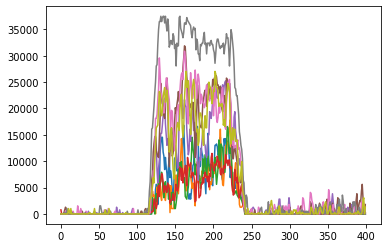

In [1]:
#차선인식 알고리즘 ( 프로젝트 완성기한 부족으로 인한 미완성.. 
#추후 도전할만한 가치가 있는 흥미로운 프로젝트라 생각되어 제출기한이 넘었더라도 작동시켜볼 계획입니다.)
import traitlets
import ipywidgets.widgets as widgets
from IPython.display import display
from matplotlib import pyplot as plt

# Camera and Motor Interface for JetBot
from jetbot import Robot, Camera, bgr8_to_jpeg

# Python basic pakcages for image annotation
from uuid import uuid1
import os
import json
import glob
import datetime
import numpy as np
import cv2
import time

robot = Robot()
target_widget = widgets.Image(format='jpeg', width=400, height=300)
camera = Camera.instance(width=400, height=300)

roi_left_bottom = (120,300)
roi_left_top = (130, 250)
roi_right_bottom = (300, 300)
roi_right_top =  (290,250)

persp_left_bottom = (120,300)
persp_left_top =  (130,250)
persp_right_bottom = (300,300)
persp_right_top = (290,250)

def white_yellow_color_detect(src):
    mask_lane = cv2.inRange(src, (80, 80, 40),(255,255,255))
    #차선영역의 색상범위에 대한 마스킹
    filter_lane = cv2.bitwise_and(src, src, mask=mask_lane)
    #차선영역 마스크와 원본 이미지 and 연산

    return filter_lane

def roi_mask(src):
    roi_mask = np.zeros_like(src)
    #검정 배경의 빈 이미지 생성
    (y, x) = (src.shape[0], src.shape[1]) 
    #원본 이미지 파일의 가로 세로값 가져오기
    pts = np.array([[roi_left_bottom,roi_right_bottom,roi_right_top,roi_left_top]], dtype=np.int32)
    #ROI 영역을 위한 좌표 리스트(배열) 선언
    cv2.fillPoly(roi_mask, pts, (255,255,255))
    #ROI 영역에 대한 도형 그리기
    mul = cv2.bitwise_and(src, roi_mask)
    #ROI 영역 제외한 영역 마스크 처리
    
    return mul

def Pers_transform(src):
    pts1 = np.array([[persp_left_bottom,persp_right_bottom,persp_right_top,persp_left_top]], dtype=np.float32)
    #원근 변환할 지점의 좌표
    pts2 = np.array([[0,src.shape[0]],[src.shape[1],src.shape[0]],[src.shape[1],0],[0,0]],dtype=np.float32)
    #변환 후 결과 이미지 좌표
    #overlap source and roi mask
    
    perspective_matrix = cv2.getPerspectiveTransform(pts1, pts2)
    #원근 변환 행렬 계산
    rev_pers_mat = cv2.getPerspectiveTransform(pts2, pts1)
    #원근 역변환 행렬 계산(원근 변환 후 처리한 영상을 다시 원래대로 돌려놓기 위한 과정)
    
    persp = cv2.warpPerspective(src, perspective_matrix, (src.shape[1],src.shape[0]))
    #원근 변환 수행
   
    return persp, rev_pers_mat #원근 변환 이미지 / 원근 역변환 행렬 반환

def plothistogram(src):
    histogram = np.sum(src[src.shape[0]//2:,:], axis = 0)
    #idpoint = np.int32(histogram.shape[0]/2)
    plt.plot(histogram)

    return histogram

def binarization(src):
    _gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(_gray, 90, 255, cv2.THRESH_BINARY)
    return ret, thresh

def display_xy(camera_image):
    image = np.copy(camera_image)
    roied = roi_mask(image)
    persp = Pers_transform(roied)[0]
    filtered = white_yellow_color_detect(persp)
    binarized = binarization(filtered)[1]
    center_lane = plothistogram(binarized)
    
    jpeg_image = bgr8_to_jpeg(binarized)
    return jpeg_image



time.sleep(1)
#traitlets.dlink((camera, 'value'), (image_widget, 'value'), transform=bgr8_to_jpeg)
traitlets.dlink((camera, 'value'), (target_widget, 'value'), transform=display_xy)

display(target_widget)

#robot.forward(0.4)

#leftbase = np.argmax(histogram[:midpoint])
#rightbase = np.argmax(histogram[midpoint:])+ midpoint

In [4]:
camera.stop()